In [1]:
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Linear Regression (y=w1+w2*x+noise)
x = np.array([-5.,2.,5.])
X = np.vstack([np.ones(len(x)),x])
y = np.array([[-5.5],[0.5],[4.5]])
x_star = np.linspace(-7.,7.,num=100)
X_star = np.vstack([np.ones(len(x_star)),x_star])

# # Nonlinear Regression (y=w1*sin(x)+w2*x+w3*x^2-w4*cos(x)+noise)
# x = np.array([-4.,-1.,1.,2.])
# X = np.vstack([np.sin(x),x,np.power(x,2),-1.*np.cos(x)])
# y = np.array([[-3.8],[-5.5],[0.5],[4.5]])
# x_star = np.linspace(-7.,7.,num=100)
# X_star = np.vstack([np.sin(x_star),x_star,np.power(x_star,2),-1.*np.cos(x_star)])

mu_0 = np.zeros(X.shape[0])
Sigma_p = np.eye(X.shape[0])
w = np.random.multivariate_normal(mean=mu_0, cov=Sigma_p, size=10000) # eq.(2.4)

A = np.dot(X,np.transpose(X)) + np.linalg.inv(Sigma_p)
inv_A = np.linalg.inv(A)
w_bar = np.linalg.multi_dot([inv_A,X,y])
w_post = np.random.multivariate_normal(mean=w_bar.flatten(), cov=inv_A, size=10000) # eq.(2.8)


mu_star = np.linalg.multi_dot([np.transpose(X_star),inv_A,X,y]).flatten()
f_star = np.random.multivariate_normal(mean=mu_star,\
                                       cov=np.linalg.multi_dot([np.transpose(X_star),inv_A,X_star]), \
                                       size=10000) # eq.(2.9)

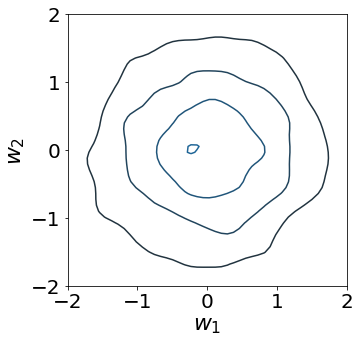

In [3]:
# Prior
fig, ax = plt.subplots(figsize=(5,5))

sns.kdeplot(w[:,0],w[:,1],n_levels=4)

ax.set_xlabel(r'$w_1$', fontsize=22)
ax.set_ylabel(r'$w_2$', fontsize=22)
ax.tick_params(labelsize=20)
ax.set_xlim([-2.,2.])
ax.set_ylim([-2.,2.])

plt.show()

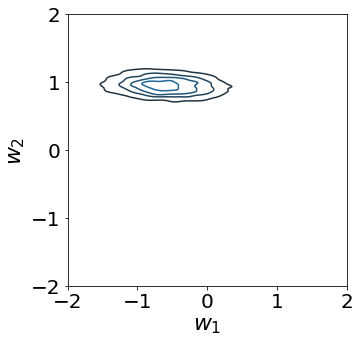

In [4]:
# Posterior
fig, ax = plt.subplots(figsize=(5,5))

sns.kdeplot(w_post[:,0],w_post[:,1],n_levels=4)

ax.set_xlabel(r'$w_1$', fontsize=22)
ax.set_ylabel(r'$w_2$', fontsize=22)
ax.tick_params(labelsize=20)
ax.set_xlim([-2.,2.])
ax.set_ylim([-2.,2.])

plt.show()

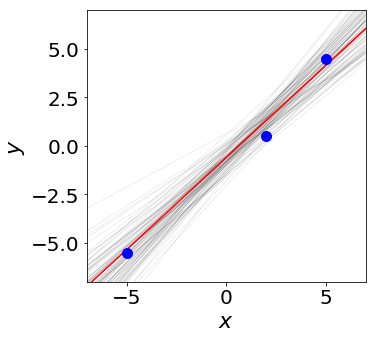

In [5]:
# Data and Predictive distribution
fig, ax = plt.subplots(figsize=(5,5))

for loop_i in range(100):
    ax.plot(x_star,f_star[loop_i,:],color='black',lw=0.2,alpha=0.3)

ax.plot(x_star,mu_star,color='red')
ax.plot(X[1,:],y,'bo',ms=10)
    
ax.set_xlabel(r'$x$', fontsize=22)
ax.set_ylabel(r'$y$', fontsize=22)
ax.tick_params(labelsize=20)
ax.set_xlim([-7.,7.])
ax.set_ylim([-7.,7.])

plt.show()

In [6]:
# Function-space View
def K(x1,x2,ell):
    return np.exp(-0.5*np.subtract.outer(x1,x2)**2/ell**2)

# f(x) = phi(x)*w
def GP(mu,K):
    u = np.random.randn(len(mu))
    L = np.linalg.cholesky(K + 5e-15*np.eye(len(u)))    # add epsilon*I for stability
    return mu + np.dot(L, u) 

x  = np.linspace(-5, 5, num=100)
mu  = np.zeros_like(x)

In [7]:
xt  = np.array([-4.,-3.,-1.,0.,2.])
yt  = np.array([-2.,0.,1.,2.,-1.])
ell = 1.

K_tt = K(xt, xt, ell)                       # Noise Free
# K_tt = K(xt, xt, ell) + .2*np.eye(len(xt))  # Noisy
invK_tt = np.linalg.inv(K_tt + 5e-15*np.eye(len(xt)))
K_ss = K(x, x, ell)
K_ts = K(xt, x, ell)

mu_post = np.linalg.multi_dot([np.transpose(K_ts), invK_tt, yt])         # posterior avg
K_post = K_ss - np.linalg.multi_dot([np.transpose(K_ts), invK_tt, K_ts]) # posterior cov
L_post = np.linalg.cholesky(K_post + 5e-15*np.eye(len(x)))    

np.random.seed()
Y = np.array([GP(mu_post, K_post) for i in range(1000)]) # draw 1000 random functions from posterior

y_avg = mu_post
y_sig = np.sqrt(np.diag(K_post))

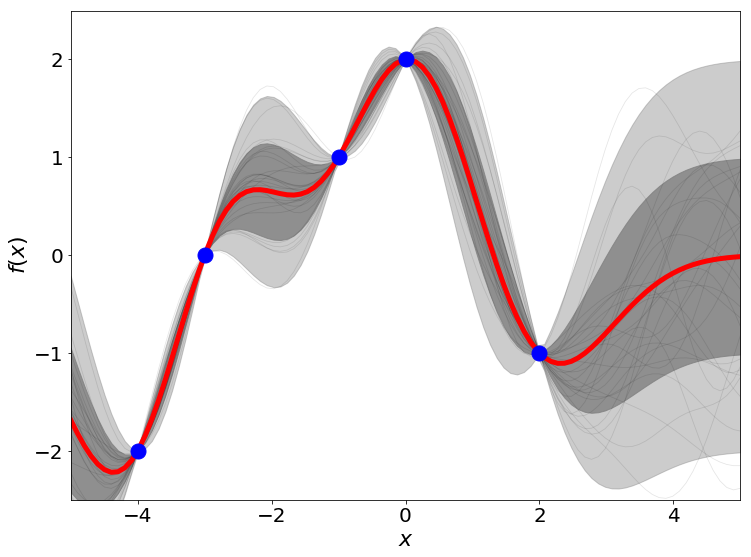

In [8]:
# Posterior Distribution
fig, ax = plt.subplots(figsize=(12,9))

ax.fill_between(x, y_avg - y_sig, y_avg + y_sig, color='grey', alpha=0.8) # avg+/-sigma
ax.fill_between(x, y_avg - 2*y_sig, y_avg + 2*y_sig, color='grey', alpha=0.4) # avg+/-2sigma
for i in range(30):
    ax.plot(x, Y[i], color='k', alpha=0.1, lw=0.8)

ax.plot(x, y_avg, color='red', lw=5) # avg posterior
ax.plot(xt, yt, ls='None', marker='o', ms=15, color='blue') # training data

ax.set_xlabel(r'$x$', fontsize=22)
ax.set_ylabel(r'$f(x)$', fontsize=22)
ax.tick_params(labelsize=20)
ax.set_xlim([-5.,5.])
ax.set_ylim([-2.5,2.5])
plt.show()

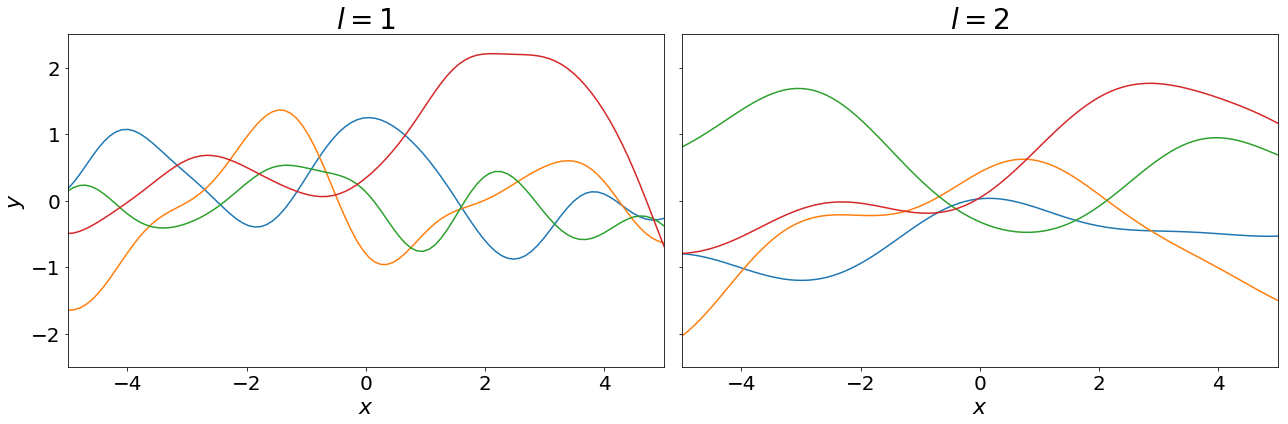

In [9]:
# Prior Distribution
# length-scale
fig, axes = plt.subplots(figsize=(18,6), ncols=2, sharex=True, sharey=True)
for i in range(4):
    axes[0].plot(x, GP(mu, K(x,x,1.)))
    axes[1].plot(x, GP(mu, K(x,x,2.)))
for ax,l in zip(axes, [r'$l=1$', r'$l=2$']):    
    ax.set_xlabel(r'$x$', fontsize=22)
    ax.set_xlim([-5.,5.])
    ax.set_ylim([-2.5,2.5])
    ax.set_title(l, fontsize=28)
    ax.tick_params(labelsize=20)
    
axes[0].set_ylabel(r'$y$', fontsize=22)

fig.tight_layout()
plt.show()

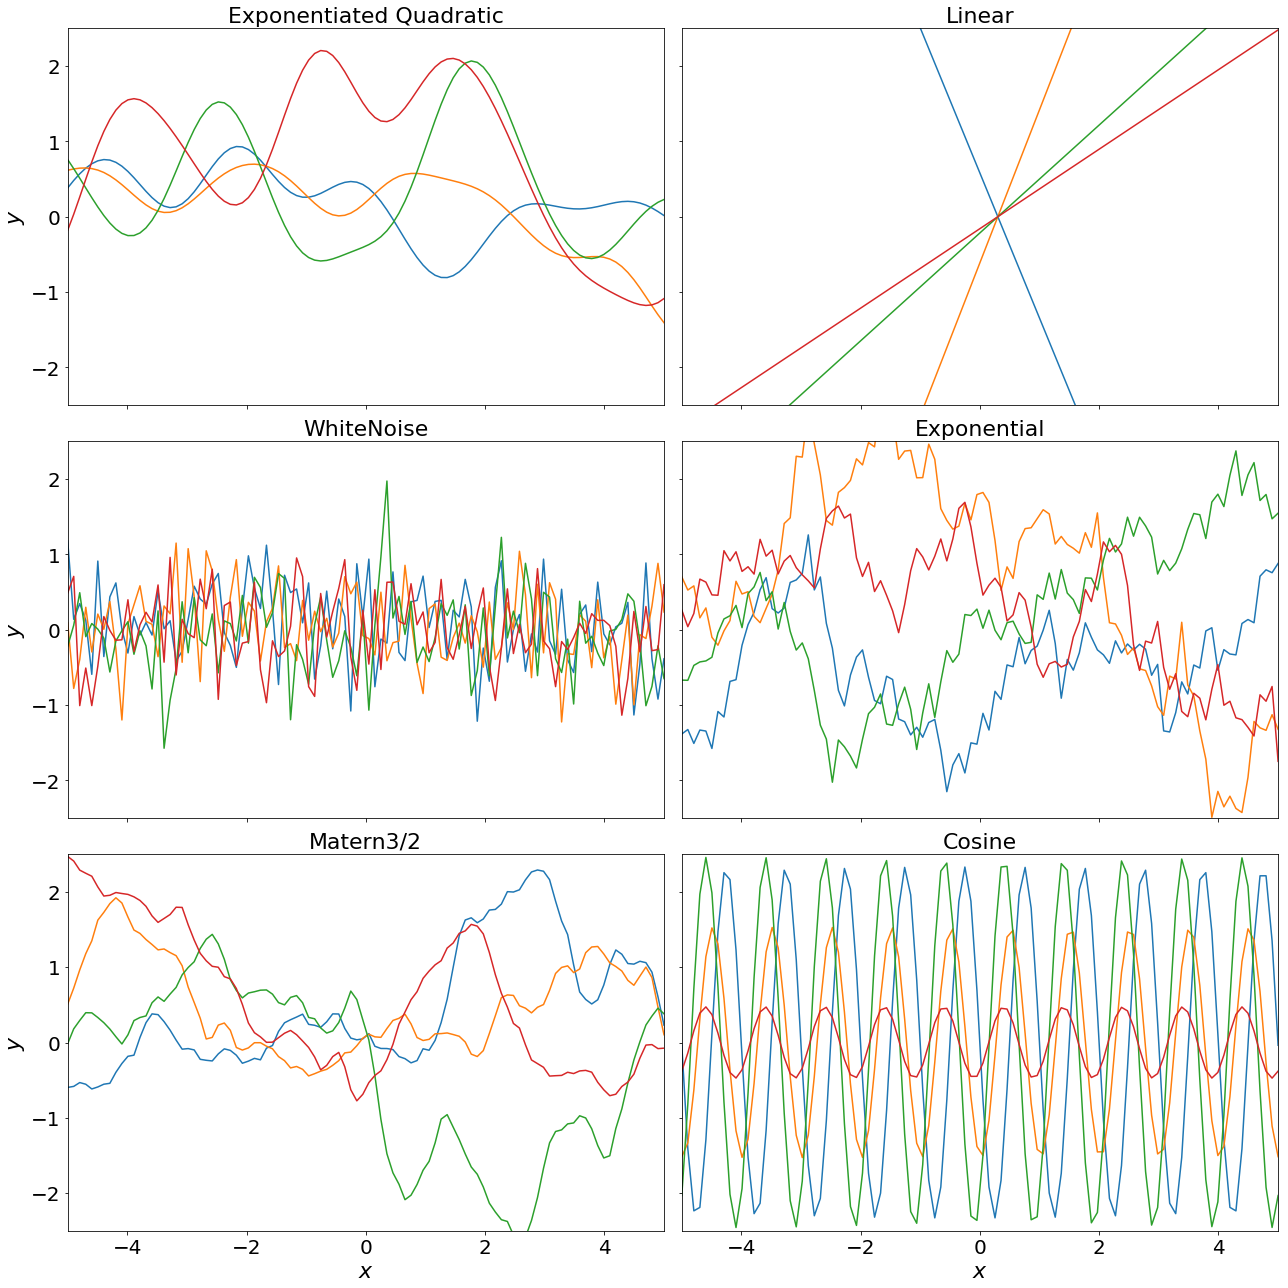

In [10]:
# kernel
# https://docs.pymc.io/api/gp/cov.html
lengthscale = 1.

cov_ExponentiatedQuadratic = pm.gp.cov.ExpQuad(1, ls=lengthscale)
cov_Linear = pm.gp.cov.Linear(1, c=0.3)
cov_WhiteNoise =  pm.gp.cov.WhiteNoise(sigma=0.5)
cov_Exponential =  pm.gp.cov.Exponential(1, ls=lengthscale)
cov_Matern32 =  pm.gp.cov.Matern32(1, ls=lengthscale)
cov_Cosine =  pm.gp.cov.Cosine(1, ls=lengthscale)

K_ExponentiatedQuadratic = cov_ExponentiatedQuadratic(x[:,None]).eval()
K_Linear = cov_Linear(x[:,None]).eval()
K_WhiteNoise = cov_WhiteNoise(x[:,None]).eval()
K_Exponential = cov_Exponential(x[:,None]).eval()
K_Matern32 = cov_Matern32(x[:,None]).eval()
K_Cosine = cov_Cosine(x[:,None]).eval()


fig, axes = plt.subplots(figsize=(18,18), ncols=2, nrows=3, sharex=True, sharey=True)

axes[0,0].plot(x, pm.MvNormal.dist(mu=np.zeros(K_ExponentiatedQuadratic.shape[0]), cov=K_ExponentiatedQuadratic).random(size=4).T)
axes[0,1].plot(x, pm.MvNormal.dist(mu=np.zeros(K_Linear.shape[0]), cov=K_Linear).random(size=4).T)
axes[1,0].plot(x, pm.MvNormal.dist(mu=np.zeros(K_WhiteNoise.shape[0]), cov=K_WhiteNoise).random(size=4).T)
axes[1,1].plot(x, pm.MvNormal.dist(mu=np.zeros(K_Exponential.shape[0]), cov=K_Exponential).random(size=4).T)
axes[2,0].plot(x, pm.MvNormal.dist(mu=np.zeros(K_Matern32.shape[0]), cov=K_Matern32).random(size=4).T)
axes[2,1].plot(x, pm.MvNormal.dist(mu=np.zeros(K_Cosine.shape[0]), cov=K_Cosine).random(size=4).T)
for ax,l in zip([axes[0,0],axes[0,1],axes[1,0],axes[1,1],axes[2,0],axes[2,1]]\
                , ['Exponentiated Quadratic', 'Linear', 'WhiteNoise', 'Exponential', 'Matern3/2', 'Cosine']):    
    ax.set_xlim([-5.,5.])
    ax.set_ylim([-2.5,2.5])
    ax.set_title(l, fontsize=22)
    ax.tick_params(labelsize=20)

axes[2,0].set_xlabel(r'$x$', fontsize=22)
axes[2,1].set_xlabel(r'$x$', fontsize=22)
axes[0,0].set_ylabel(r'$y$', fontsize=22)
axes[1,0].set_ylabel(r'$y$', fontsize=22)
axes[2,0].set_ylabel(r'$y$', fontsize=22)


fig.tight_layout()
plt.show()

In [11]:
# Infer the Hyperparameters (pymc3)
with pm.Model() as model:
    log_ell = pm.Uniform("log_ell",lower=-5.,upper=5.)
    ell = pm.Deterministic("ell",tt.exp(log_ell))
    
    cov = pm.gp.cov.ExpQuad(1,ls=ell)
#     cov = pm.gp.cov.Matern32(1,ls=ell)
#     cov = pm.gp.cov.Cosine(1,ls=ell)
    
    gp = pm.gp.Marginal(cov_func=cov)
    
    y_ = gp.marginal_likelihood("y_",X=xt[:,None],y=yt,noise=0.)

#     trace = pm.sample(draws=5000)
    mp = pm.find_MAP(start={'log_ell':1.,'ell':0})

/Users/seryonaoki/anaconda3/envs/ML/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -11.847, ||grad|| = 0.83789: 100%|██████████| 19/19 [00:00<00:00, 865.37it/s]  


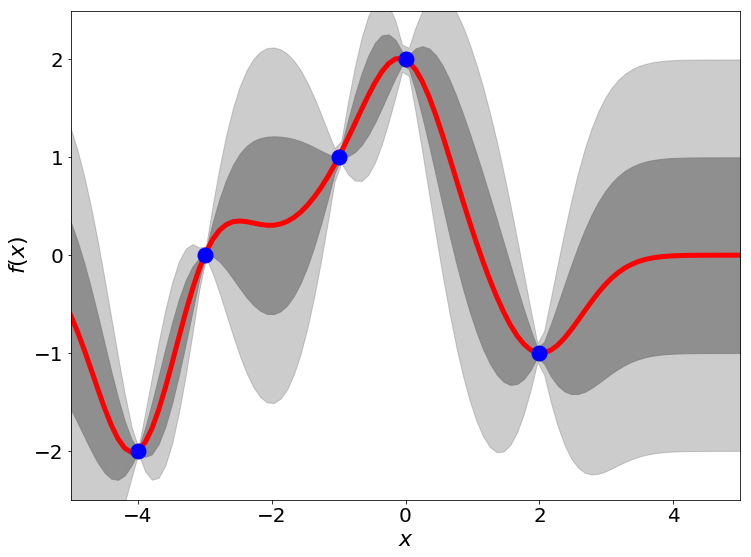

In [12]:
# Posterior Distribution
with model:
    mu, var = gp.predict(x[:,None],point=mp,diag=False)
    sd = np.sqrt(np.diag(var))
    
fig, ax = plt.subplots(figsize=(12,9))

ax.fill_between(x, mu - sd, mu + sd, color='grey', alpha=0.8) # avg+/-sigma
ax.fill_between(x, mu - 2*sd, mu + 2*sd, color='grey', alpha=0.4) # avg+/-2sigma

ax.plot(x, mu, color='red', lw=5) # avg posterior
ax.plot(xt, yt, ls='None', marker='o', ms=15, color='blue') # training data

ax.set_xlabel(r'$x$', fontsize=22)
ax.set_ylabel(r'$f(x)$', fontsize=22)
ax.tick_params(labelsize=20)
ax.set_xlim([-5.,5.])
ax.set_ylim([-2.5,2.5])
plt.show()